... Continued from part 2

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import datetime
from datetime import timedelta
import statsmodels.api as sm
from pandas import concat
from tqdm import tqdm
from prettytable import PrettyTable
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import GRU
import tensorflow as tf
from tensorflow.keras import metrics
from statsmodels.tsa.arima.model import ARIMA
import math
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import joblib
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
warnings.warn("deprecated", DeprecationWarning)
pd.set_option('display.max_columns', None)

In [ ]:
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'casestudy')
drive.mount(MOUNTPOINT)
dirPath = os.getcwd()
print(dirPath)

Mounted at /content/gdrive
/content


In [ ]:
# Load data
df = pd.read_excel(dirPath+'/gdrive/My Drive/casestudy2/dfseries.xlsx')

In [ ]:
df

,start_time,total,run_time,pass,no_run,fail,exec_count
0,2016-01-04,964,6.098808,919,2,43,42
1,2016-01-05,1441,5.716791,219,449,773,82
2,2016-01-06,4257,15.538374,1977,1961,319,94
3,2016-01-07,4148,33.325904,3665,11,472,128
4,2016-01-08,1002,7.131022,941,50,11,46
...,...,...,...,...,...,...,...
754,2018-01-27,2074,10.934531,367,52,1655,77
755,2018-01-28,6363,14.067379,474,2404,3485,122
756,2018-01-29,6706,17.891077,825,2473,3408,150
757,2018-01-30,4569,17.840890,775,1605,2189,95


In [ ]:
df.index = df.start_time
df.drop(columns='start_time',axis=1, inplace=True)
df.head(3)

,total,run_time,pass,no_run,fail,exec_count
start_time,,,,,,
2016-01-04,964,6.098808,919,2,43,42
2016-01-05,1441,5.716791,219,449,773,82
2016-01-06,4257,15.538374,1977,1961,319,94


## Mulitvariate - Multi Step Forecasting

Now we will add relevant features to the 'Start_time' feature which we had used for Univariate Forecasting earlier.

This will make it a multi variate forecasting.

We will predict/forecast - 7 days into the future. Making it a multistep forecasting.

During EDA we found that features, PASS and EXEC_COUNT had a good influence on the runtime. Hence we will use these features.

Data Processing

In [ ]:
dfmul = df.copy()

In [ ]:
dfmul.drop(index = dfmul[dfmul['run_time']>100].index, axis=0, inplace=True) # Remove anomalies.

In [ ]:
len(dfmul)

749

In [ ]:
dfmul

,total,run_time,pass,no_run,fail,exec_count
start_time,,,,,,
2016-01-04,964,6.098808,919,2,43,42
2016-01-05,1441,5.716791,219,449,773,82
2016-01-06,4257,15.538374,1977,1961,319,94
2016-01-07,4148,33.325904,3665,11,472,128
2016-01-08,1002,7.131022,941,50,11,46
...,...,...,...,...,...,...
2018-01-27,2074,10.934531,367,52,1655,77
2018-01-28,6363,14.067379,474,2404,3485,122
2018-01-29,6706,17.891077,825,2473,3408,150


In [ ]:
dfmul.drop(columns=['total','no_run','fail'], axis=1, inplace=True)

In [ ]:
dfmul.head(2)

,run_time,pass,exec_count
start_time,,,
2016-01-04,6.098808,919,42
2016-01-05,5.716791,219,82


In [ ]:
# Define Utility Functions
modelScore = {}

def mv_visualize_results(modelName, y_test, y_pred):
  act = []
  pred = []
  for i in range(len(y_test)):
    act.append(y_test[i].mean()) # Average of 7 day timewindow
    pred.append(y_pred[i].mean())
  fig,ax = plt.subplots(figsize=(20,8))
  plt.plot(act,color='green')
  plt.plot(pred,color='red')
  plt.xlabel('Date')
  plt.ylabel('Runtime')
  plt.title(modelName+': Actual vs. Predicted Runtime')
  plt.legend(['Actual', 'Predicted'])
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(labelbottom=False)   
  plt.show()

def mv_find_rmse(actual, predictions):
  act = []
  pred = []
  for i in range(len(actual)):
    act.append(actual[i].mean())
    pred.append(predictions[i].mean())
  return np.round(np.sqrt(((np.array(act)-np.array(pred))**2).mean()),3)

def multivariate_time_window_3d(timeSeries, timeSteps, futureSteps):
  '''
  Featurizes multi variate time series into previous timeSteps 
  Returns a 3 dim X input. 
  '''
  X = []
  y = []
  for i in range(len(timeSeries)):
    if i+timesteps+futureSteps > len(timeSeries):
      break
    X.append(timeSeries[i:i+timeSteps])
    y_l = []
    for j in range(i+timesteps, i+timesteps+futureSteps):
      y_l.append(timeSeries[j][0])
    y.append(y_l)
  X = np.array(X)
  y = np.array(y)
  return X,y

def multivariate_time_window_2d(timeSeries, timeSteps, futureSteps):
  '''
  Featurizes time series into previous timeSteps 
  Returns a 2 dim X input. 
  '''
  X = []
  y = []
  for i in range(len(timeSeries)):
    if i+timesteps+futureSteps > len(timeSeries):
      break
    X_l=[]
    for k in range(i, i+timeSteps):
      for f in range(3):
        X_l.append(timeSeries[k][f])    
    X.append(X_l)
    y_l = []
    for j in range(i+timesteps, i+timesteps+futureSteps):
      y_l.append(timeSeries[j][0])
    y.append(y_l)
  X = np.array(X)
  y = np.array(y)
  return X,y

def save_model(model,model_name):
  model_json = model.to_json()
  with open(dirPath+"/gdrive/My Drive/casestudy/model_save/"+model_name+".json", "w") as jsonfile:
    jsonfile.write(model_json)

In [ ]:
# Train Test Split
size = int(len(dfmul) * 0.75)
timesteps = 5 # Tuned value. Use past five days runtimes to predict one step in the future.
train = dfmul.values[0:size]
test = dfmul.values[size:]

In [ ]:
X_train, y_train = multivariate_time_window_2d(train, timeSteps=5, futureSteps=7)
X_test, y_test = multivariate_time_window_2d(test, timeSteps=5, futureSteps=7)

In [ ]:
# normalize the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

###Show case the featurization:

Below is the validation part of the dataset - as an example.

In [ ]:
test[:10]

array([[  47.37706194, 3044.        ,  114.        ],
       [  31.09579806, 2388.        ,   78.        ],
       [  27.92684583, 2295.        ,   80.        ],
       [  61.29126861, 3345.        ,  110.        ],
       [  42.52006417, 3488.        ,  123.        ],
       [  40.836535  , 3279.        ,  125.        ],
       [  40.02727694, 2940.        ,  111.        ],
       [  32.16934806, 1988.        ,  114.        ],
       [  19.31702722, 1154.        ,   78.        ],
       [  25.61333167, 2248.        ,   80.        ]])

In [ ]:
Xdash, ydash = multivariate_time_window_2d(test, timeSteps=5, futureSteps=7)
print(Xdash)
print(ydash)

[[  47.37706194 3044.          114.         ...   42.52006417
  3488.          123.        ]
 [  31.09579806 2388.           78.         ...   40.836535
  3279.          125.        ]
 [  27.92684583 2295.           80.         ...   40.02727694
  2940.          111.        ]
 ...
 [  46.39424556 3046.           97.         ...   30.8506675
  1714.           81.        ]
 [  23.75942028  841.           73.         ...   10.71905472
   391.           75.        ]
 [  45.64140861 3734.           85.         ...    9.49921889
   348.           69.        ]]
[[40.836535   40.02727694 32.16934806 ... 25.61333167 38.93397417
  39.63513722]
 [40.02727694 32.16934806 19.31702722 ... 38.93397417 39.63513722
  30.43722694]
 [32.16934806 19.31702722 25.61333167 ... 39.63513722 30.43722694
  33.40087   ]
 ...
 [10.71905472  9.49921889 10.12469806 ... 10.93453139 14.06737944
  17.89107667]
 [ 9.49921889 10.12469806 10.84929889 ... 14.06737944 17.89107667
  17.84089028]
 [10.12469806 10.84929889 10.

In [ ]:
print(Xdash.shape)
print(ydash.shape)

(177, 15)
(177, 7)


As we can see above, the multivariate_time_window_2d function, featurises the validation dataset into 15 features - ie. 3 features(runtime, pass, exec_count) for each of the 5 time steps in the past. - in a 2d Matrix - for use by Regression Models.

And the to predict value ydash is actually a vector with 7 dimensions, each dimension is a day in the future to predict - multistep in a single prediction.

In [ ]:
Xdash, ydash = multivariate_time_window_3d(test, timeSteps=5, futureSteps=7)
print(Xdash)
print(ydash)

[[[  47.37706194 3044.          114.        ]
  [  31.09579806 2388.           78.        ]
  [  27.92684583 2295.           80.        ]
  [  61.29126861 3345.          110.        ]
  [  42.52006417 3488.          123.        ]]

 [[  31.09579806 2388.           78.        ]
  [  27.92684583 2295.           80.        ]
  [  61.29126861 3345.          110.        ]
  [  42.52006417 3488.          123.        ]
  [  40.836535   3279.          125.        ]]

 [[  27.92684583 2295.           80.        ]
  [  61.29126861 3345.          110.        ]
  [  42.52006417 3488.          123.        ]
  [  40.836535   3279.          125.        ]
  [  40.02727694 2940.          111.        ]]

 ...

 [[  46.39424556 3046.           97.        ]
  [  23.75942028  841.           73.        ]
  [  45.64140861 3734.           85.        ]
  [  30.28730361 1289.           83.        ]
  [  30.8506675  1714.           81.        ]]

 [[  23.75942028  841.           73.        ]
  [  45.64140861 373

In [ ]:
print(Xdash.shape)
print(ydash.shape)

(177, 5, 3)
(177, 7)


Here we can see similar results as with the above 2d function, just that in this case of multivariate_time_window_3d - each timestep in the past is a vector of 3 dimensions - for the 3 features. So each row is a 5 dimensional vector of 3 dimensional vectors - for use my deep learning models.

### Linear Regression

In [ ]:
modelName = 'Linear Regression'
model = LinearRegression()
model.fit(X_train_sc, y_train)
y_pred = []
y_pred = model.predict(X_test_sc)

RMSE score: 7.809


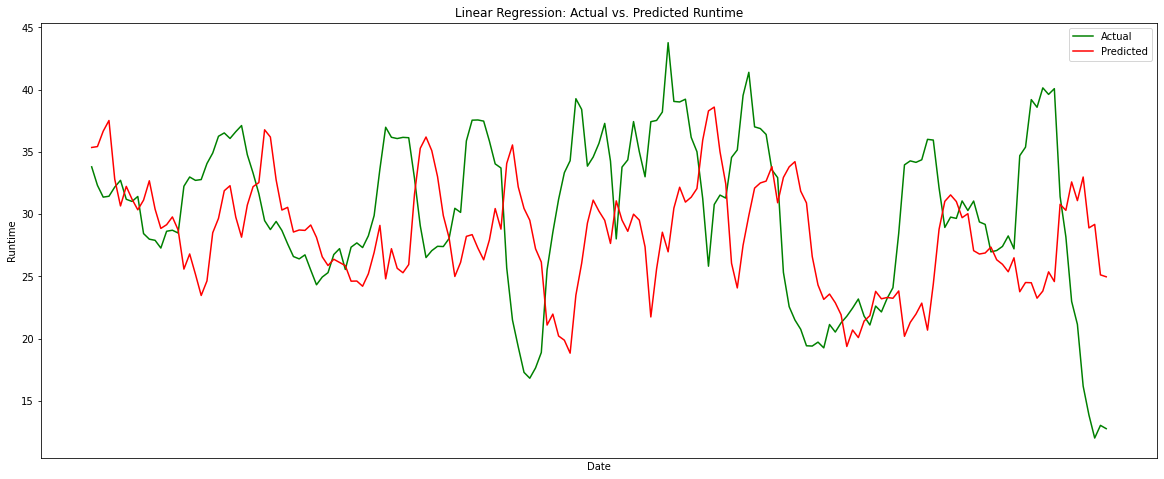

In [ ]:
score = mv_find_rmse(y_test,y_pred)
print("RMSE score:",score)
mv_visualize_results(modelName, y_test, y_pred)
modelScore[modelName] = score

### Random Forest

In [ ]:
# Tune Hyper parameters
regressor = RandomForestRegressor(random_state=101)
parameters = {'n_estimators':[5,10,50 ,100],'max_depth':[1, 5, 10, 50, None], 'min_samples_split':[2, 5, 10, 100, 500], 'min_samples_leaf':[1, 5, 10, 100, 500]}
grid_cv = GridSearchCV(regressor, parameters, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train_sc,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestmin_samples_splitrf = grid_cv.best_params_['min_samples_split']
bestn_estimatorsrf = grid_cv.best_params_['n_estimators']
bestmax_depthrf = grid_cv.best_params_['max_depth']
bestmin_samples_leafrf = grid_cv.best_params_['min_samples_leaf']

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
modelName = 'Random Forest'
modelrf = RandomForestRegressor(n_estimators = bestn_estimatorsrf, min_samples_split = bestmin_samples_splitrf ,max_depth  = bestmax_depthrf, min_samples_leaf  =bestmin_samples_leafrf , random_state=101)
modelrf.fit(X_train_sc, y_train)
y_pred = []
y_pred = modelrf.predict(X_test_sc)

RMSE score: 7.07


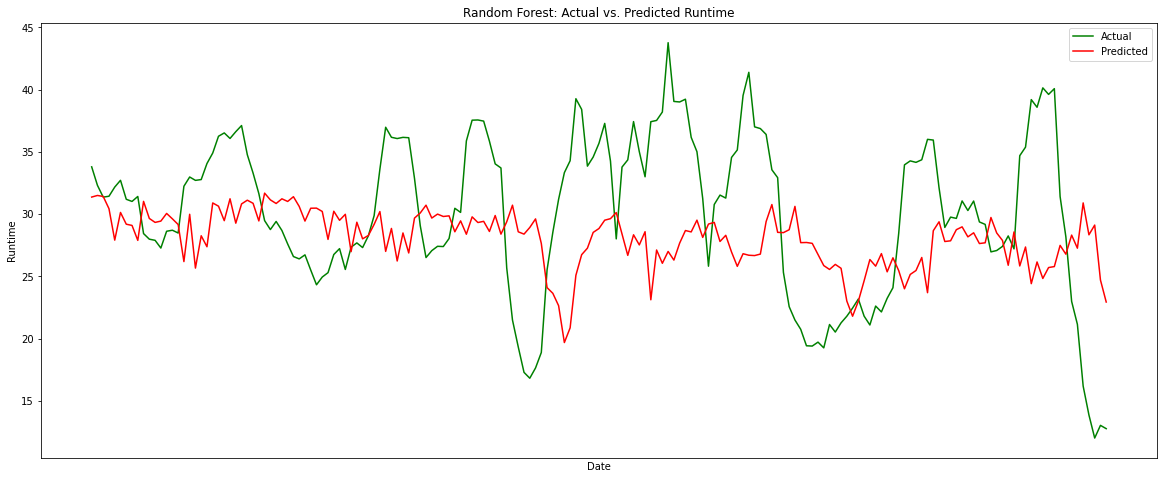

In [ ]:
score = mv_find_rmse(y_test,y_pred)
print("RMSE score:",score)
mv_visualize_results(modelName, y_test, y_pred)
modelScore[modelName] = score

In [ ]:
# save the model to disk
filename = dirPath+"/gdrive/My Drive/casestudy/model_save/rfmul.sav"
pickle.dump(modelrf, open(filename, 'wb'))

There is very significant improvement in the results when features like 'pass' and 'exec_count' are added to the training data.

We see that Random Forest has performed better than Linear Regression here.

### GRU Deep Learning Network

We will define a stacked GRU network to train the multivariate dataset.

In [ ]:
X_train, y_train = multivariate_time_window_3d(train, timeSteps=5, futureSteps=7)
X_test, y_test = multivariate_time_window_3d(test, timeSteps=5, futureSteps=7)

In [ ]:
# normalize the data
scaler = StandardScaler()
X_train_sc_lst = []
for i in range(len(X_train)):
  X_train_sc_lst.append(scaler.fit_transform(X_train[i]))
X_train_sc = np.array(X_train_sc_lst)

X_test_sc_lst = []
for i in range(len(X_test)):
  X_test_sc_lst.append(scaler.transform(X_test[i]))
X_test_sc = np.array(X_test_sc_lst)

In [ ]:
def define_model():
  n_features = 3
  timeSteps = 5
  modeldl = Sequential()
  modeldl.add(GRU(64, activation='relu', return_sequences=True, input_shape=(timesteps, n_features)))
  modeldl.add(GRU(16, activation='relu', return_sequences=True))
  modeldl.add(GRU(8, activation='relu'))
  modeldl.add(Dense(1))
  modeldl.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return modeldl

In [ ]:
checkpoint = ModelCheckpoint(filepath=dirPath+"/gdrive/My Drive/casestudy/model_save/model_mul.hdf5", monitor= 'val_root_mean_squared_error', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, verbose=1, mode='min')
modelName = 'GRU_mul'
# Model Definition
modeldl = define_model()

In [ ]:
modeldl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             13248     
                                                                 
 gru_1 (GRU)                 (None, 5, 16)             3936      
                                                                 
 gru_2 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 17,817
Trainable params: 17,817
Non-trainable params: 0
_________________________________________________________________


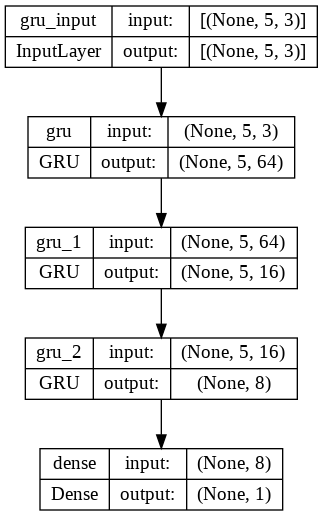

In [ ]:
tf.keras.utils.plot_model(modeldl, to_file=dirPath+'/gdrive/My Drive/casestudy/'+modelName+'.png', show_shapes=True)

In [ ]:
# Save the model definition
save_model(modeldl,modelName)

In [ ]:
h = modeldl.fit(X_train_sc, y_train, epochs=300, verbose=1, callbacks=[earlystop,checkpoint], validation_data=(X_test_sc, y_test)) #
print('Best RMSE: ',min(h.history['val_root_mean_squared_error']))

Epoch 1/300
16/18 [=========================>....] - ETA: 0s - loss: 685.6204 - root_mean_squared_error: 26.1844
Epoch 1: val_root_mean_squared_error improved from inf to 32.35349, saving model to /content/gdrive/My Drive/casestudy/model_save/model_mul.hdf5
18/18 [==============================] - 6s 70ms/step - loss: 676.6729 - root_mean_squared_error: 26.0129 - val_loss: 1046.7480 - val_root_mean_squared_error: 32.3535
Epoch 2/300
18/18 [==============================] - ETA: 0s - loss: 657.7474 - root_mean_squared_error: 25.6466
Epoch 2: val_root_mean_squared_error improved from 32.35349 to 31.29757, saving model to /content/gdrive/My Drive/casestudy/model_save/model_mul.hdf5
18/18 [==============================] - 0s 20ms/step - loss: 657.7474 - root_mean_squared_error: 25.6466 - val_loss: 979.5378 - val_root_mean_squared_error: 31.2976
Epoch 3/300
15/18 [========================>.....] - ETA: 0s - loss: 537.3992 - root_mean_squared_error: 23.1819
Epoch 3: val_root_mean_squared_er

In [ ]:
score = np.round(min(h.history['val_root_mean_squared_error']),3)
print('Best RMSE: ',score)
modelScore[modelName] = score

Best RMSE:  13.839


In [ ]:
pt = PrettyTable()
pt.field_names = ['Model', 'RMSE Score']
pt.add_row(['Baseline Model', 15.31])
pt.add_row(['Linear Regression-Univariate',  12.602])
pt.add_row(['Linear Regression-Multivariate',  modelScore['Linear Regression']])
pt.add_row(['Random Forest-Univariate',  12.165])
pt.add_row(['Random Forest-Multivariate',  modelScore['Random Forest']])
pt.add_row(['GRU Network-Multivariate', modelScore['GRU_mul']])
print(pt)

+--------------------------------+------------+
|             Model              | RMSE Score |
+--------------------------------+------------+
|         Baseline Model         |   15.31    |
|  Linear Regression-Univariate  |   12.602   |
| Linear Regression-Multivariate |   7.809    |
|    Random Forest-Univariate    |   12.165   |
|   Random Forest-Multivariate   |    7.07    |
|    GRU Network-Multivariate    |   13.839   |
+--------------------------------+------------+


We see that Multi Variate Forecasting has done lot better than Univariate Forecasting.

Random Forest has given the best performance.

## Mulitvariate, Multistep out of sample forecasting with Anomaly Detection

During the EDA based on inferences from plots and from domain expertise, we had fixed runtime of more than 100 hours as the threshold to detect anomalies.

We will incorporate this with the Random Forest Forecasting model to detect any anomalies into the future.

In [ ]:
def detect_anomaly(runtime):
  anomaly_threshold = 100
  if runtime > anomaly_threshold:
    return True
  else:
    return False

In [ ]:
df_full = df.copy()
df_full.drop(columns=['total','no_run','fail'], axis=1, inplace=True)

In [ ]:
df_full.head(3)

,run_time,pass,exec_count
start_time,,,
2016-01-04,6.098808,919,42
2016-01-05,5.716791,219,82
2016-01-06,15.538374,1977,94


In [ ]:
# Train with the entire dataset
X_tr, y_tr = multivariate_time_window_2d(df_full[:].values, timeSteps=5, futureSteps=7)
# Input to predict 1st out of sample value
X_te, y_te = multivariate_time_window_2d(df_full[-5:].values, timeSteps=5, futureSteps=0)

In [ ]:
# normalize the data
scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_te_sc = scaler.transform(X_te)
joblib.dump(scaler, open(dirPath+'/gdrive/My Drive/casestudy/scaler.pkl','wb'))

In [ ]:
# Random Forest
modelrf = RandomForestRegressor(n_estimators = bestn_estimatorsrf, min_samples_split = bestmin_samples_splitrf ,max_depth  = bestmax_depthrf, min_samples_leaf  =bestmin_samples_leafrf , random_state=101)
modelrf.fit(X_tr_sc, y_tr)
joblib.dump(modelrf, open(dirPath+'/gdrive/My Drive/casestudy/rfmul.pkl','wb'))

In [ ]:
y_forecast = modelrf.predict(X_te)

Forecast for next 7 days:
              run_time  Anomaly_Flag
2018-02-01  43.931956         False
2018-02-02  35.213238         False
2018-02-03  34.118257         False
2018-02-04  34.184781         False
2018-02-05  37.645652         False
2018-02-06  34.444063         False
2018-02-07  38.707207         False


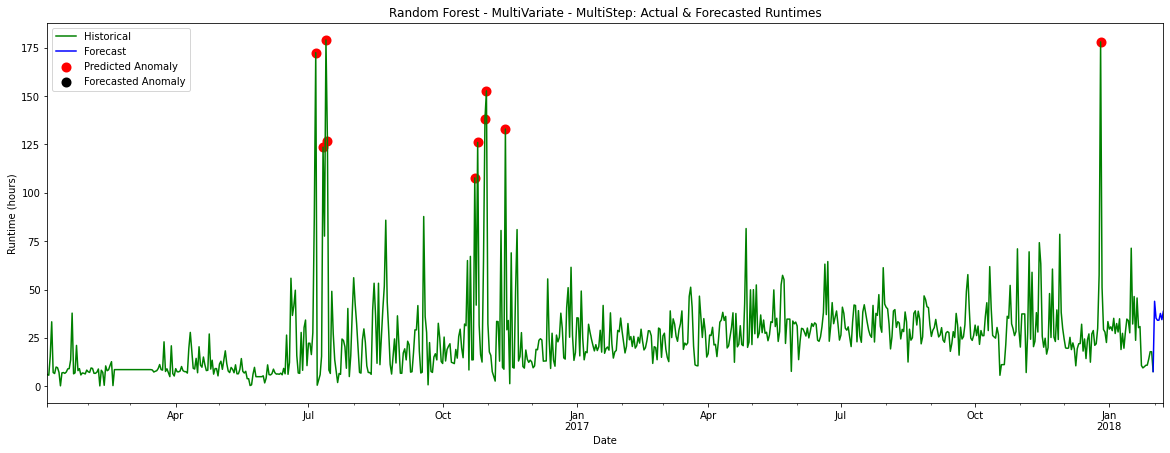

In [ ]:
# Create a new dataframe with forecasted results.
modelName = 'Random Forest - MultiVariate - MultiStep'
dateIndex = pd.date_range(df_full.index[-1] + timedelta(days=1) , df_full.index[-1] + timedelta(days=7) , freq='D')
dfF = pd.DataFrame(columns=['run_time'])
dfF.loc[df_full.index[-1]] = df_full['run_time'][-1]
dfForecast = pd.DataFrame(data = y_forecast.reshape(7,1), columns = ['run_time'], index= dateIndex)
dfForecast = pd.concat([dfF, dfForecast], axis=0)

# Set Anomaly Flags
df_full['Anomaly_Flag'] = df_full['run_time'].apply(detect_anomaly)
dfForecast['Anomaly_Flag'] = dfForecast['run_time'].apply(detect_anomaly)
print('Forecast for next 7 days:\n',dfForecast[1:8])

# Visualize
ax = df_full['run_time'].plot(label='Historical', figsize=(20, 7),color='green')
dfForecast['run_time'].apply(lambda x : 0 if x<0 else x).plot(ax=ax, label='Forecast', color='blue')
plt.scatter(x= df_full[df_full['Anomaly_Flag']==1].index, y= df_full[df_full['Anomaly_Flag']==True]['run_time'],color='red', label = 'Predicted Anomaly',linewidths=4)
plt.scatter(x= dfForecast[dfForecast['Anomaly_Flag']==1].index, y= dfForecast[dfForecast['Anomaly_Flag']==1]['run_time'],color='black', label = 'Forecasted Anomaly',linewidths=4)
plt.xlabel('Date')
plt.ylabel('Runtime (hours)')
plt.title(modelName+': Actual & Forecasted Runtimes')
plt.legend()
plt.show()

We do not have any anomalies forecasted for the next 7 days.

## Confidence Interval
We will use bootstrapping of samples to arrive at the 95% confidence interval of the forecast.

In [ ]:
# Train Test Split
size = int(len(dfmul) * 0.75)
timesteps = 5 # Tuned value. Use past five days runtimes to predict one step in the future.
train = dfmul.values[0:size]
test = dfmul.values[size:]

samp_size = int(len(train)*0.5)
predList = []
for i in tqdm(range(100)): # 100 set of random samples
  samp_index = np.random.choice(train.shape[0], samp_size, replace=False)  
  X_train, y_train = multivariate_time_window_2d(train[samp_index], timeSteps=5, futureSteps=7)
  X_test, y_test = multivariate_time_window_2d(test, timeSteps=5, futureSteps=7)

  # normalize the data
  scaler = StandardScaler()
  X_train_sc = scaler.fit_transform(X_train)
  X_test_sc = scaler.transform(X_test)


  modelrf = RandomForestRegressor(n_estimators = bestn_estimatorsrf, min_samples_split = bestmin_samples_splitrf ,max_depth  = bestmax_depthrf, min_samples_leaf  =bestmin_samples_leafrf , random_state=101)
  modelrf.fit(X_tr_sc, y_tr)

  y_forecast = modelrf.predict(X_test_sc)
  lst_7dayAvg = []
  for i in range(len(y_forecast)):
    lst_7dayAvg.append(y_forecast[i].mean()) # 7 days average from each forecast.
  predList.append(np.mean(lst_7dayAvg)) # Average runtime predicted per iteration.

In [ ]:
# Calculate 95% Confidence Interval Thresholds
ci_dict = {}
ci_dict['lower'] = np.percentile(predList, 2.5)/np.percentile(predList, 50)
ci_dict['upper'] = np.percentile(predList, 97.5)/np.percentile(predList, 50)

**Summary**

The Random Forest MultiVariate-MultiStep forecasting with Anomaly Detection worked best and will be deployed.